In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os

In [5]:
run_range = range(0,10)
blocks_range = range(1,3)
simulation_range = range(0,2)

num_samples = 40000;

alphas = np.zeros((num_samples, len(run_range), len(blocks_range), len(simulation_range), 3))
taus   = np.zeros((num_samples, len(run_range), len(blocks_range), len(simulation_range)))

alphas_true = np.zeros((len(simulation_range), 3))
taus_true = np.zeros((len(simulation_range)))


results_directory = "Results/Simulations"

depth = 3
alpha_strs = ["no", "one_back", "two_back", "three_back"]
alpha_names = ["alpha_concentration_" + alpha_strs[dd] + "_context" for dd in range(depth)]


for sim_idx, sim_num in enumerate(simulation_range):
    for run_idx, run_num in enumerate(run_range):
        for block_idx, block_num in enumerate(blocks_range):
            filename = "{results_directory}/Sim_{sim_num}_block_{block_num}_run_{run_num}.pkl".format(results_directory=results_directory, sim_num=sim_num, block_num=block_num, run_num=run_num)
            if(not os.path.isfile(filename)):
                raise RuntimeError("Results file not found: " + filename)
                # throw error
            
            # load file
            with open(filename, "rb") as results_file:
                results = pickle.load(results_file)


                nwarmup = results["samples"]["num_warmup_samples"]
                for ii in range(3):
                    alphas[:,run_idx,block_idx,sim_idx,ii] = results["samples"]["alphas"][nwarmup:,ii]
                taus[:,run_idx,block_idx,sim_idx] = np.exp(results["samples"]["log_taus"][nwarmup:,0])

                for ii, pname in enumerate(alpha_names):
                    alphas_true[sim_idx,ii] = results["true_parameters"][pname]
                taus_true[sim_idx] = results["true_parameters"]["within_session_A_time_constant"]

In [21]:
median_alphas = np.median(alphas,axis=0)
median_taus = np.median(taus,axis=0)




,alpha_0,alpha_1,alpha_2,tau,sim
0,1,2,3,4,true


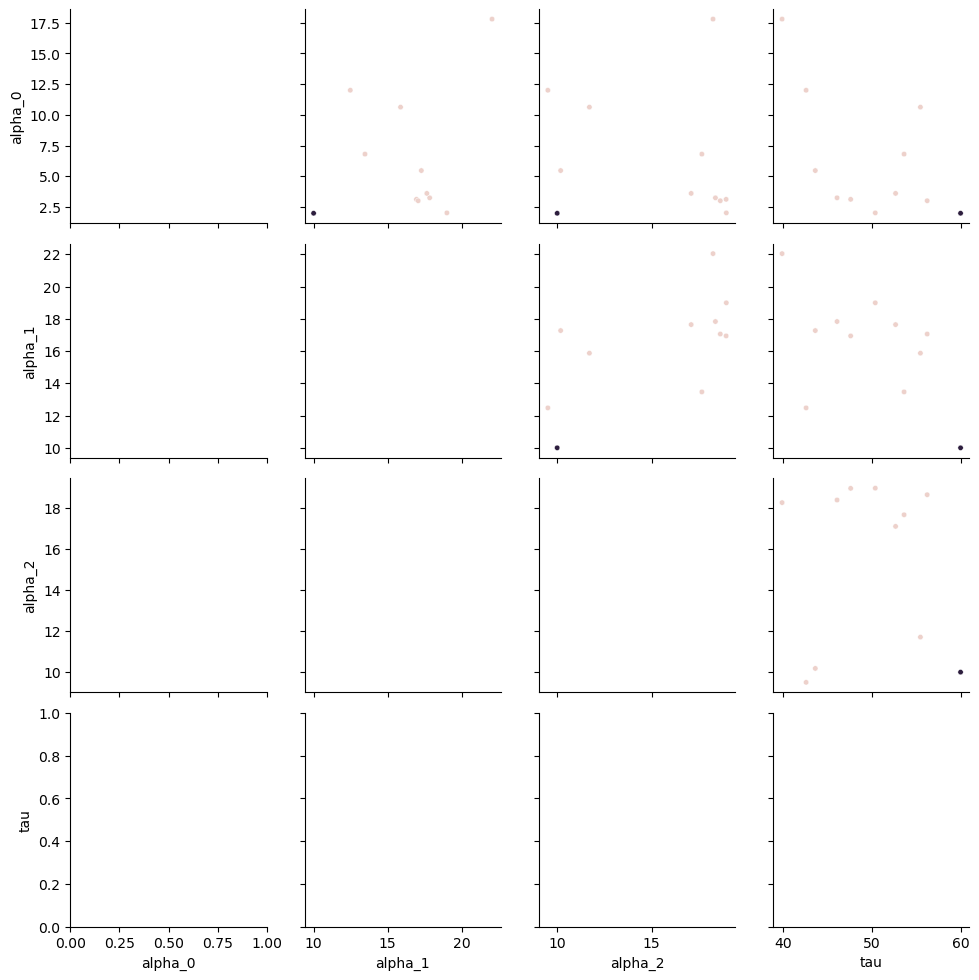

In [29]:
sim_nums = [0];
block_num = 1;

true_size = 20;
sim_size = 10;

df = pd.DataFrame(columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "size"])
for sim_num in sim_nums:
    sim_idx = simulation_range.index(sim_num) 
    block_idx = blocks_range.index(block_num)

    vars_1 = [median_alphas[:,block_idx,sim_idx,:].squeeze(), median_taus[:,block_idx,sim_idx][:,np.newaxis], 
                sim_num*np.ones((median_taus.shape[0],1), dtype=int),
                sim_size*np.ones((median_taus.shape[0],1), dtype=int)]

    df_c = pd.DataFrame(np.concatenate(vars_1,axis=1), columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "size"])
    df = pd.concat([df,df_c])

    df_c = pd.DataFrame(np.array([alphas_true[sim_idx,0], alphas_true[sim_idx,1], alphas_true[sim_idx,2], taus_true[sim_idx],
                    sim_num, true_size])[np.newaxis,:],
                    columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "size"])
    df = pd.concat([df,df_c])
    
g = sns.PairGrid(df, diag_sharey=False, hue="sim", vars=["alpha_0", "alpha_1", "alpha_2", "tau"])
g.map_upper(sns.scatterplot, s=15)

